In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os, sys
from pathlib import Path
from tqdm import tqdm
from collections import defaultdict, Counter
import pickle
import pdb
import datetime
from glob import glob
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Image as IImage


def show_dct(dct, n=3):
    return dict(list(dct.items())[:n])


pdata = Path('/data/utkface/')
p = Path('.')
from fastai import *
from fastai.vision import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
target = 'age'

In [7]:
df = pd.read_csv('img2targets.csv', usecols=['img_name', target, 'is_train'])
# df = pd.read_csv('img2targets.csv', usecols=['img_name', target, 'is_train']).sample(1000)

In [8]:
df[target]

0        35
1        30
2        18
3        26
4        36
5        50
6        17
7        34
8        17
9        54
10       65
11       75
12       58
13       30
14       28
15       58
16       23
17       37
18        1
19       24
20       26
21       70
22       41
23        2
24       26
25       28
26       35
27       21
28       51
29       52
         ..
23675    46
23676    10
23677    90
23678    24
23679    56
23680    63
23681    64
23682    55
23683    35
23684    76
23685    34
23686    52
23687    26
23688    24
23689    10
23690     1
23691    29
23692    24
23693     1
23694    38
23695    67
23696    46
23697    26
23698    43
23699    70
23700    75
23701    10
23702    28
23703     9
23704     3
Name: age, Length: 23705, dtype: int64

In [35]:
def get_dataset(df):
    ds = ImageClassificationDataset(df.img_name, df[target])
    ds.y = df[target].values[:, None].astype('float32')
    ds.c = 1
    ds.loss_func = F.l1_loss
    return ds

train_ds = get_dataset(df[df.is_train==1])
valid_ds = get_dataset(df[df.is_train==0])

def get_data(sz, bs):
    return ImageDataBunch.create(train_ds, valid_ds, path=p, bs=bs, size=sz,
                            ds_tfms=get_transforms()).normalize(imagenet_stats)

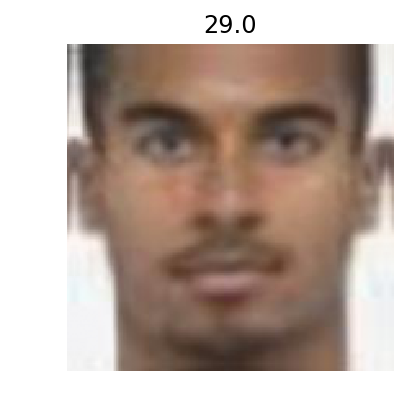

In [36]:
data = get_data(sz=200, bs=64)

i = np.random.choice(len(data.valid_ds))
img,y = data.valid_ds[i]

img.show(title=y[0])

In [37]:
learn = create_cnn(data, models.resnet50)

In [38]:
def train_size(sz, bs, lr):
    learn.data=get_data(sz, bs)
    learn.freeze()
    learn.fit_one_cycle(5, slice(lr))
    learn.unfreeze()
    learn.fit_one_cycle(5, slice(lr/20, lr/2), pct_start=0.1)
    learn.save(f"{target}-{sz}")

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


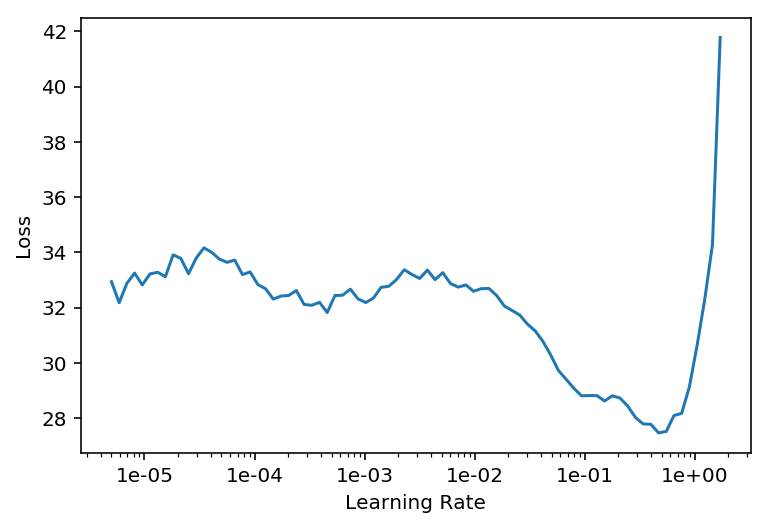

In [39]:
sz, bs = 200, 8 

learn.data=get_data(sz, bs)

learn.lr_find(start_lr=1e-6)
learn.recorder.plot()

In [41]:
lr=1e-2

In [42]:
train_size(sz, bs, lr)

Total time: 12:38
epoch  train_loss  valid_loss
1      14.204471   564.279358  (02:34)
2      12.710217   24.991791   (02:35)
3      11.125519   10.210242   (02:31)
4      11.082458   10.972696   (02:29)
5      9.949615    10.627416   (02:27)

